In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [2]:
train = pd.read_csv("data/assignment1_data/train.csv")
test = pd.read_csv("data/assignment1_data/test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [3]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [4]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


Сначала разберемся, какие признаки есть в датасете

In [5]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [6]:
not_var_feature = [
    feature for feature in train.columns
    if 'var_' not in feature
]

not_var_feature

['ID_code', 'target']

In [7]:
train[not_var_feature].tail()

,ID_code,target
199995,train_199995,0
199996,train_199996,0
199997,train_199997,0
199998,train_199998,0
199999,train_199999,0


In [8]:
train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

Поняли, что в нашем датасете 200000 строк и 202 столбца, из них 200 числовых столбцов, называющихся var_0...var_199, один столбец ID_code со значениями train_0...train_199999.

Целевая переменная target со значениями 0 и 1, причем 1 встречается в 10% случаев.

Проверим наличие дискретных признаков

In [9]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 and feature != 'target'
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 0


In [10]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<100 and feature != 'target'
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 0


Признаков, принимающих менее 100 различных значений, нет.

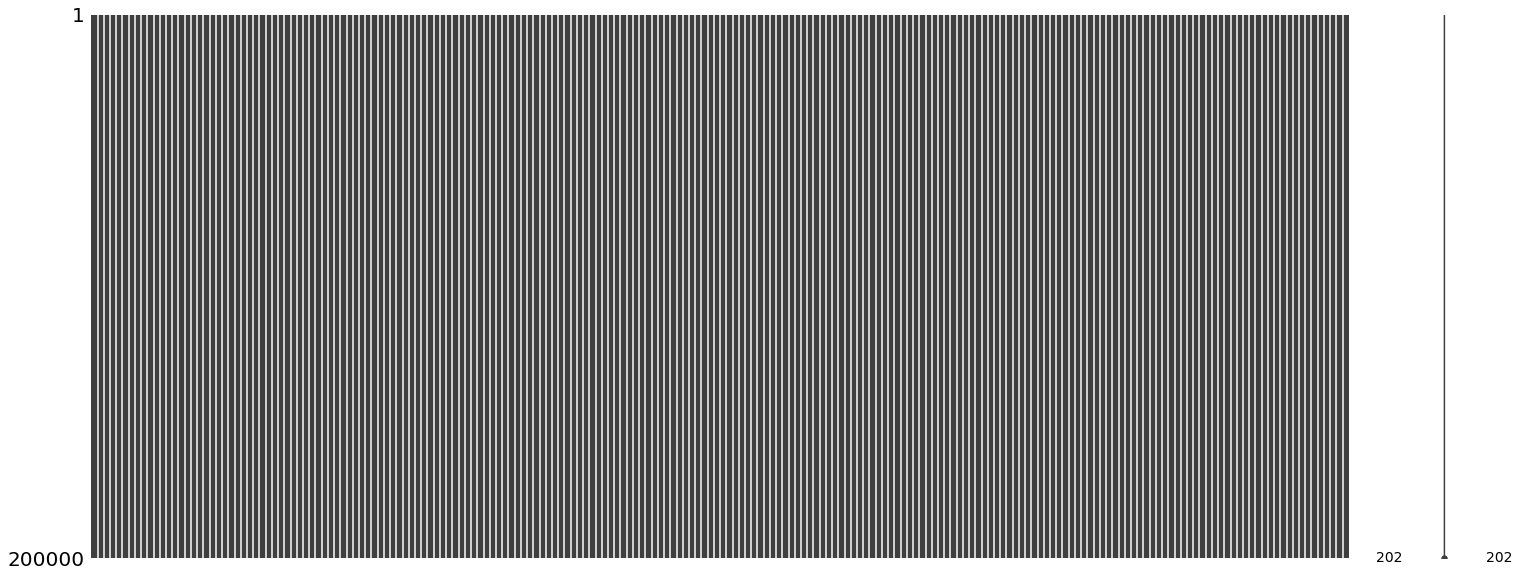

In [11]:
msno.matrix(train)

In [19]:
features_with_na = [
    feature for feature in train.columns
    if train[feature].isnull().sum() > 1]
features_with_na

[]

Пропусков в признаках нет.

Непрерывные признаки

In [25]:
continuous_feature = [
    feature for feature in train.columns
    if 'var_' in feature
]
print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 200


In [21]:
several_feature = ['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10', 'var_13', 'var_20', 'var_26', 'var_40', \
                   'var_55', 'var_80', 'var_106', 'var_109', 'var_139', 'var_175', 'var_184', 'var_196']

Для непрерывные признаков имеет смысл строить гистрограммы распределения или функции распределения, а также зависимость непрерывного признака в разрезе целевой переменной. Кроме того, имеет смысл строить распределение __одновременно__ и для обучающей выборки, и для тестовой для понимания насколько отличаются распределения.

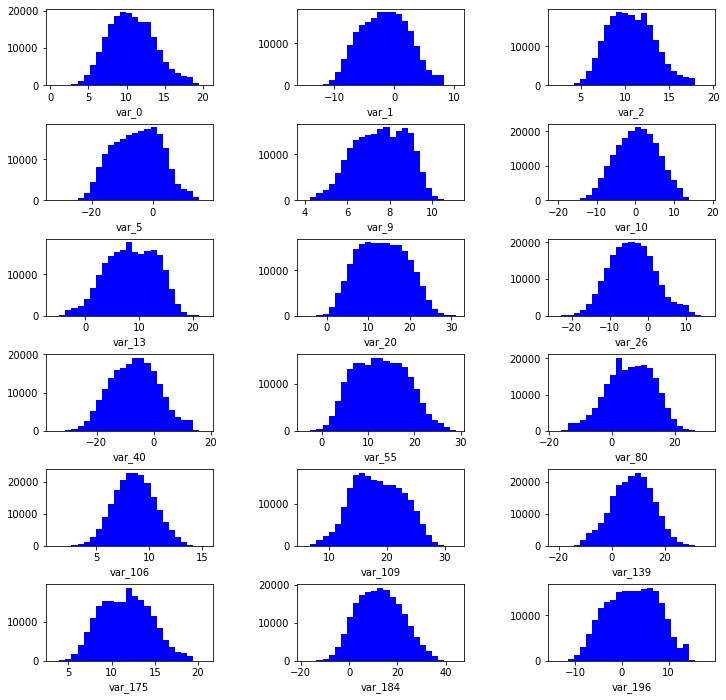

In [22]:
fig, axes = plt.subplots(6, 3, figsize=(12, 12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for num, feature in enumerate(several_feature):
    data = train[feature].copy()
    axes[num//3, num%3].hist(data, bins=25, color="blue")
    axes[num//3, num%3].set_xlabel(feature, fontsize=10)

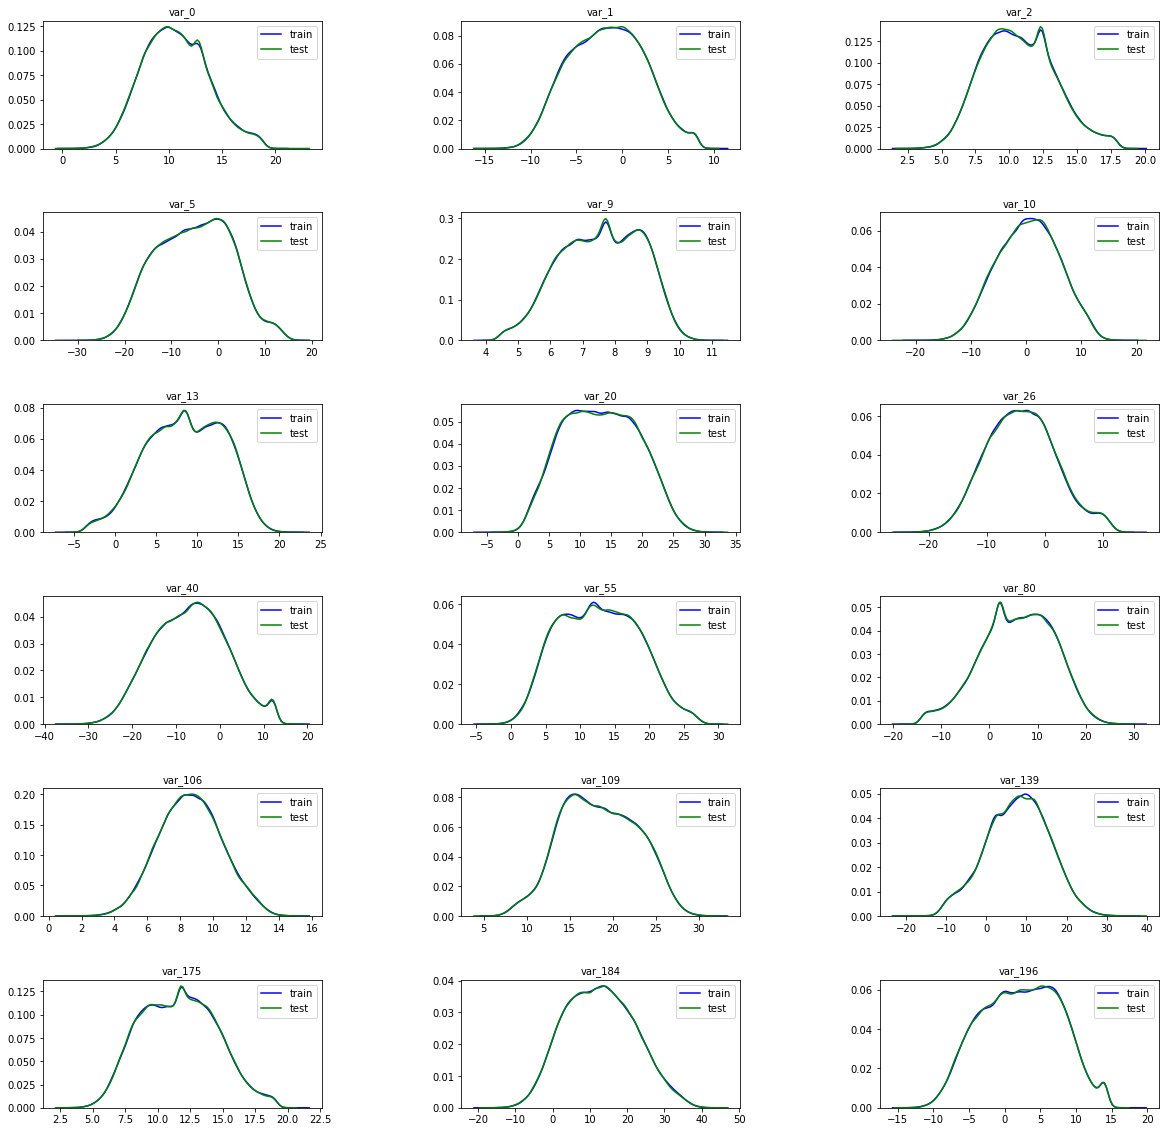

In [16]:
fig, axes = plt.subplots(6, 3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for num, feature in enumerate(several_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//3, num%3], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
    axes[num//3, num%3].set_title(feature, fontsize=10)

Видим, что распределение переменных на трейне и тесте практически совпадает.

Теперь посмотрим распеределение признаков, в зависимости от значения целевой переменной

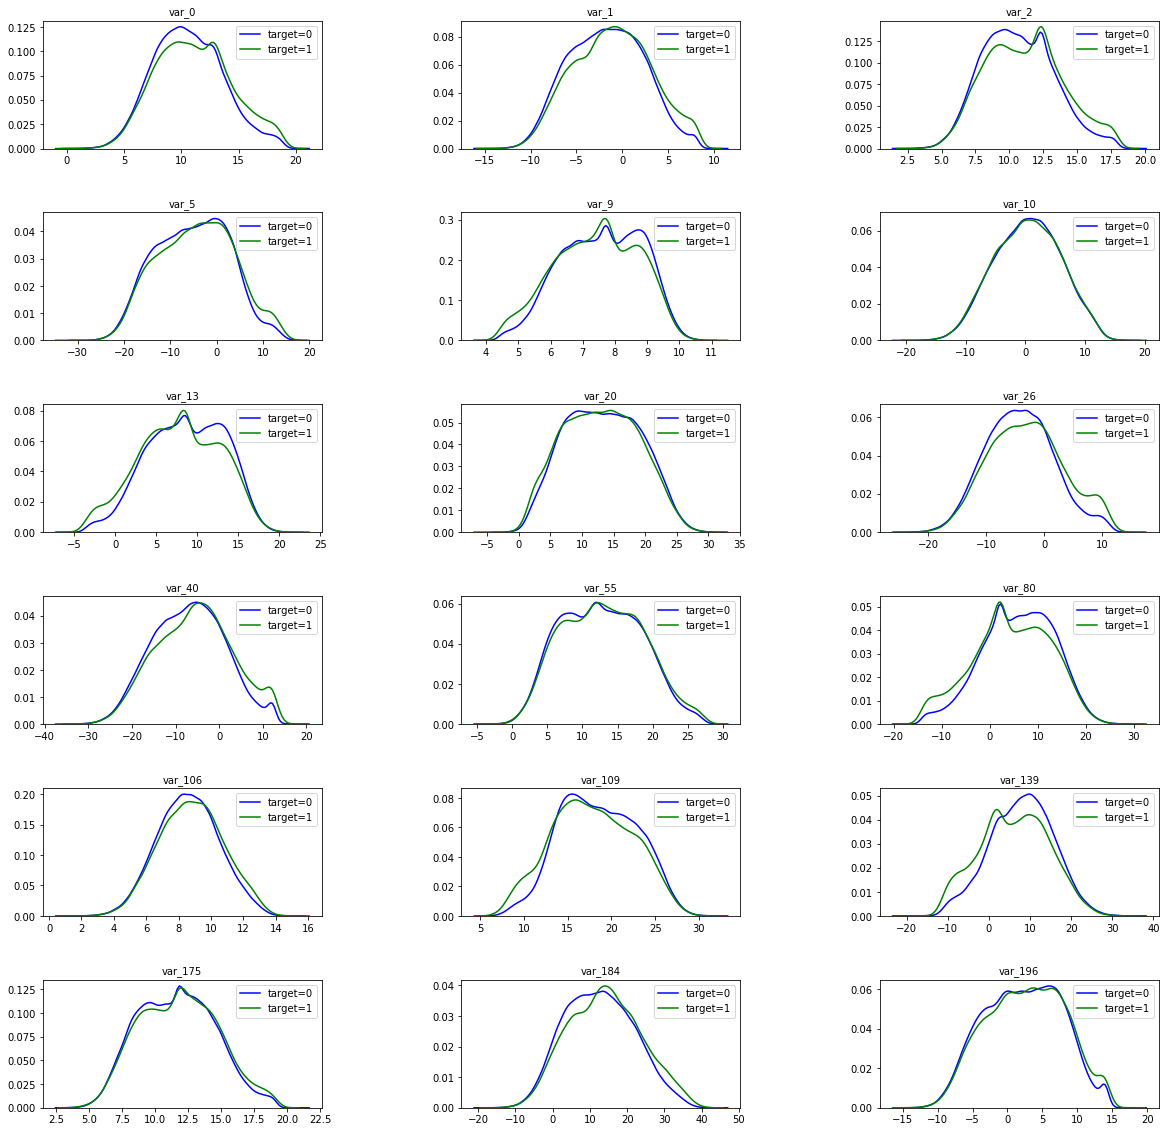

In [17]:
fig, axes = plt.subplots(6, 3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for num, feature in enumerate(several_feature):
    try:
        train0, train1 = train[train['target'] == 0][feature].copy(), train[train['target'] == 1][feature].copy()
        sns.kdeplot(train0, ax=axes[num//3, num%3], color="blue", label="target=0")
        sns.kdeplot(train1, ax=axes[num//3, num%3], color="green", label="target=1")
    except RuntimeError:
        pass
    except KeyError:
        train0 = train[train['target'] == 0][feature].copy()
        sns.kdeplot(train0, ax=axes[num//3, num%3], color="blue", label="target=0")
    axes[num//3, num%3].set_title(feature, fontsize=10)

Видим, что некоторые признаки очень похоже распределены для разных значений целевой переменной, поэтому они скорее всего не будут оказывать влияние при построении модели, поэтому их лучше исключить из итоговой модели.

Это признаки 10, 20, 55, 106 (хотя отличие есть, но небольшое), 175, 196.

Теперь посмотрим распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной

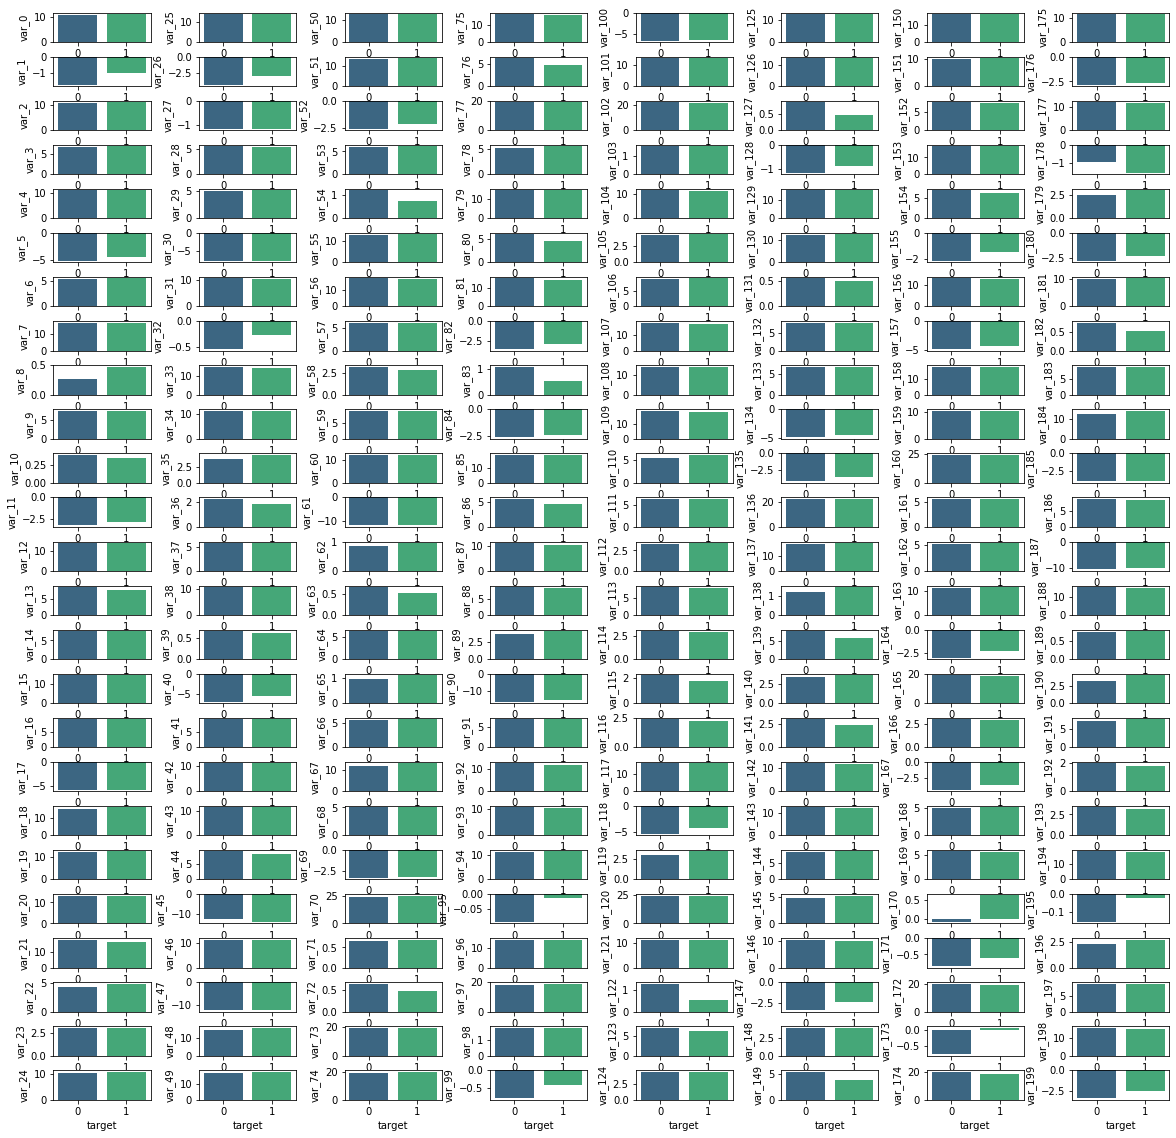

In [33]:
fig, axes = plt.subplots(25, 8, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for num, feature in enumerate(continuous_feature):
    data = train.copy()
    statistics = data.groupby(['target'])[feature].mean()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num%25, num//25]
    )
    axes[num%25, num//25].set_ylabel(feature)

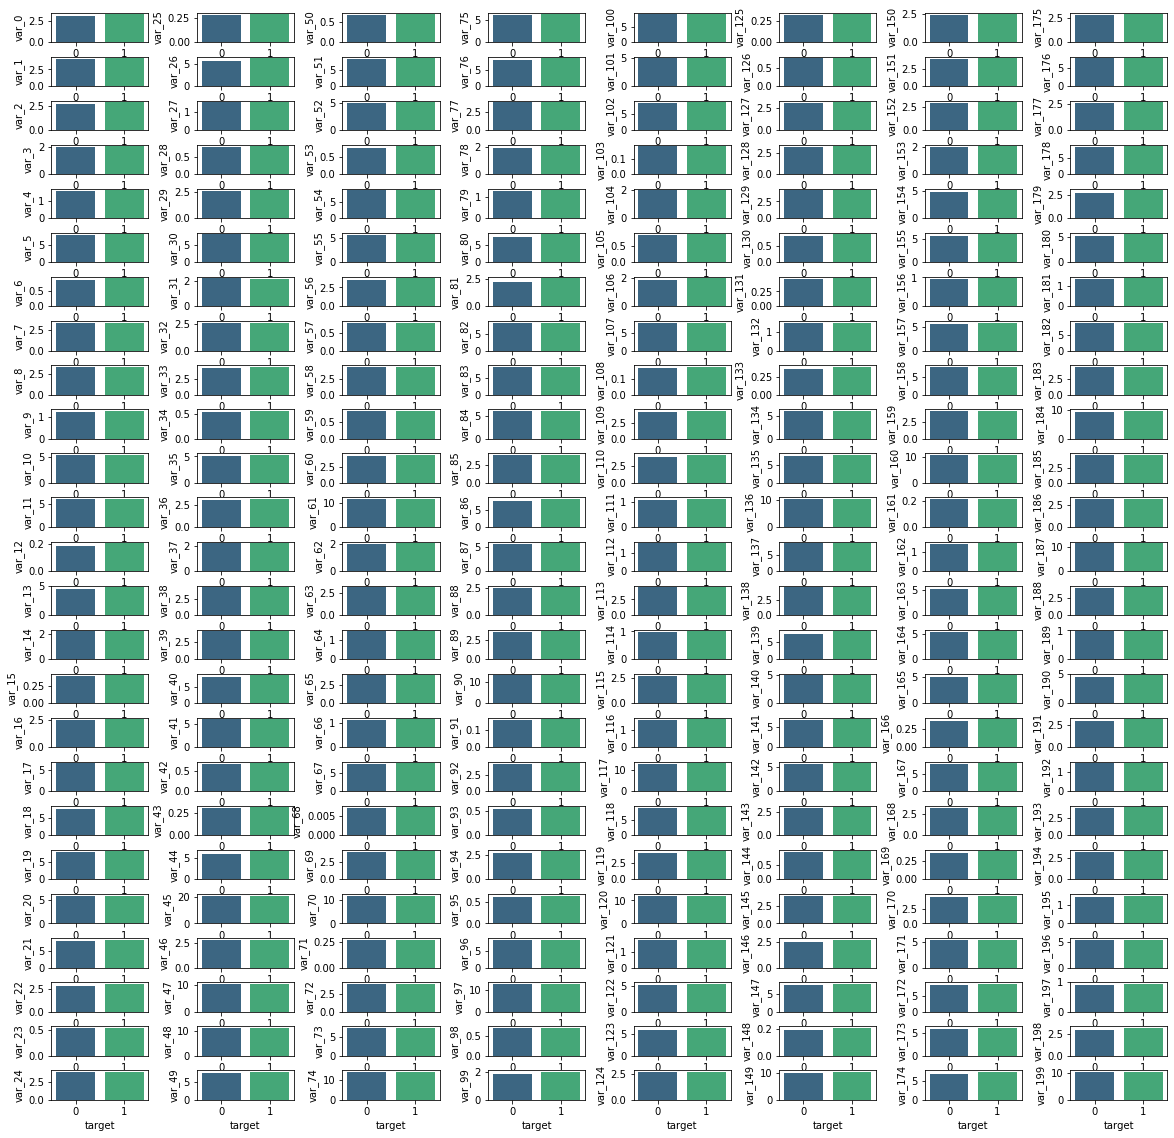

In [54]:
fig, axes = plt.subplots(25, 8, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for num, feature in enumerate(continuous_feature):
    data = train.copy()
    statistics = data.groupby(['target'])[feature].std()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num%25, num//25]
    )
    axes[num%25, num//25].set_ylabel(feature)

In [44]:
df = pd.concat([train, test], axis=0, sort=False)
df['target_flag'] = np.where(df['target'].isnull(), 1, 0)

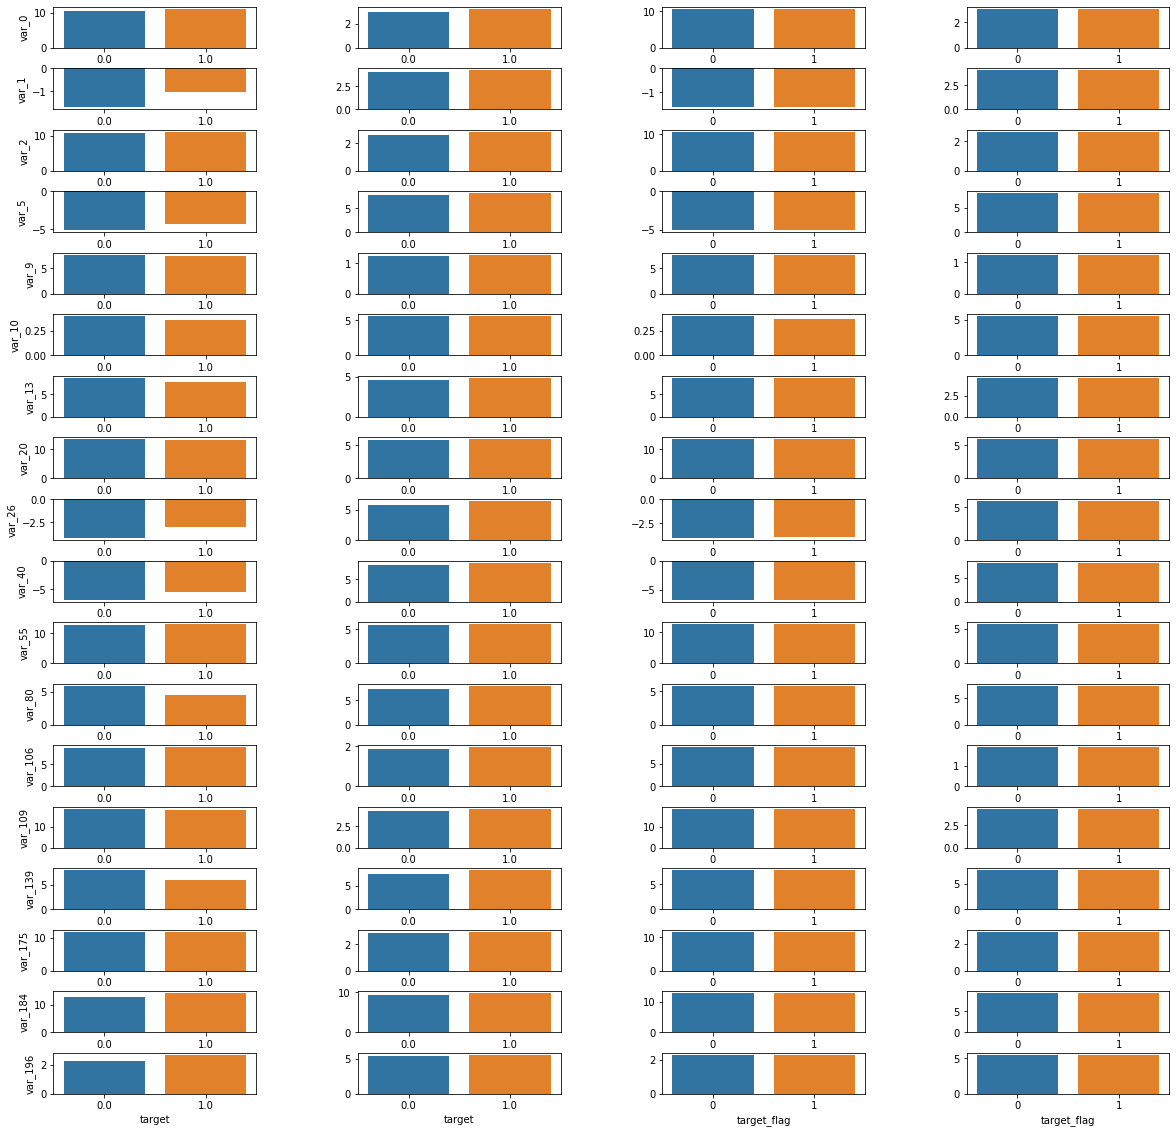

In [53]:
fig, axes = plt.subplots(18, 4, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for num, feature in enumerate(several_feature):
    
    statistics = data.groupby(['target'])[feature].mean()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        #palette="viridis",
        ax=axes[num, 0]
    )
    
    statistics = data.groupby(['target'])[feature].std()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        #palette="viridis",
        ax=axes[num, 1]
    )
    
    data = df.copy()
    statistics = data.groupby(['target_flag'])[feature].mean()
    
    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        #palette="viridis",
        ax=axes[num, 2]
    )
    
    statistics = data.groupby(['target_flag'])[feature].std()
    
    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        #palette="viridis",
        ax=axes[num, 3]
    )
    
    axes[num, 0].set_ylabel(feature)

Наиболее сильно различаются мат ожидания для разных значений целевой переменной для признаков: 32,127,178,95,99,170,195,173. За счет этого их влияние на модель должно быть более существенным. Стандартные отклонения различаются не сильно (и в целом не очень большие величины), что хорошо. Сещественных отличий в средних значениях и стандартных отклонениях для признаков на рейне и тесте обнаружино не было.

#### Корреляция между признаками

Найдем признаки, для которых значение корреляции не менее 0.2 по абсолютной величине.

In [49]:
correlation = numerical_features.corr()

In [50]:
corr_list = []
for i in range(200):
    lst = correlation[abs(correlation[f'var_{i}']) >= 0.2].index.tolist()
    lst.remove(f'var_{i}')
    if lst:
        corr_list.append([i, lst])
        
corr_list

[]

Таких признаков не оказалось. Корреляция (линейная) между признаками отсутствует. Для наглядности можно еще построить тепорвую карту

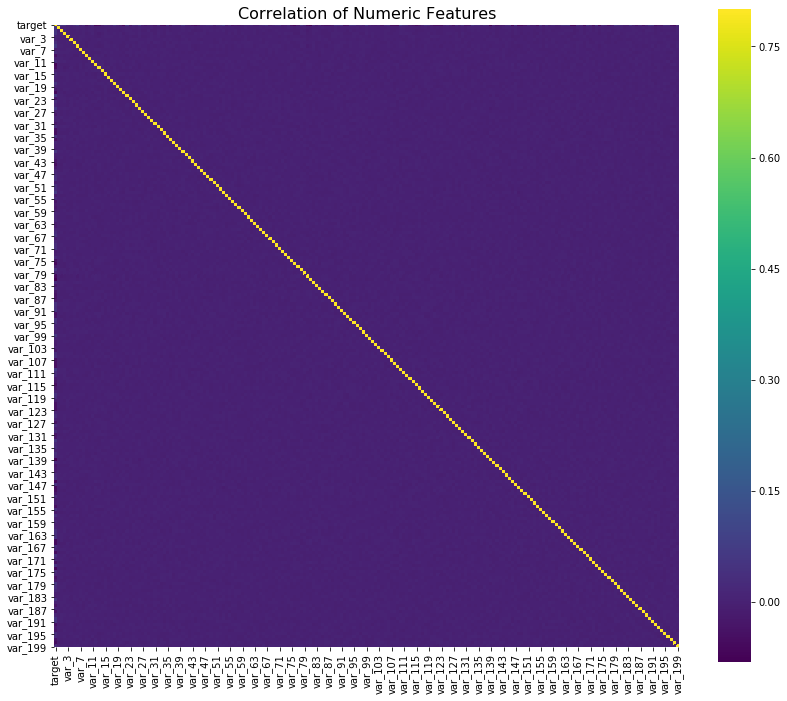

In [51]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

На тепловой карте также видим, что линейная корреляция отсутствует

Определим 10 наиболее значимых признаков с помощью случайного леса

In [56]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestClassifier(**parameters)
forest.fit(train[continuous_feature], train.target)

Wall time: 47.8 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=2,
                       oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

Text(0.5, 1.0, 'What are the top important features to start with?')

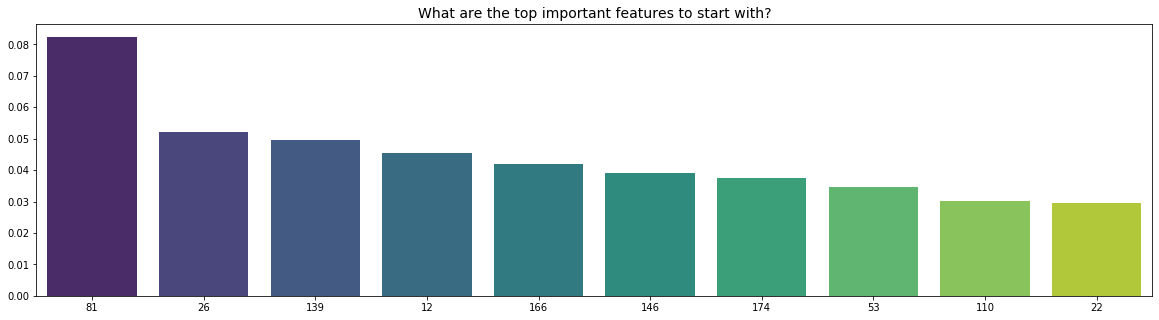

In [57]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]

plt.figure(figsize=(20, 5))
sns.barplot(x=idx, y=importances[idx], palette="viridis", order = idx)
plt.title("What are the top important features to start with?", size=14)

In [58]:
important_feature = ['var_81', 'var_26', 'var_139', 'var_12', 'var_166', 'var_146', 'var_174', 'var_53', 'var_110', 'var_22']

Сравним распределения наиболее важных признаков для двух значений целевой переменной

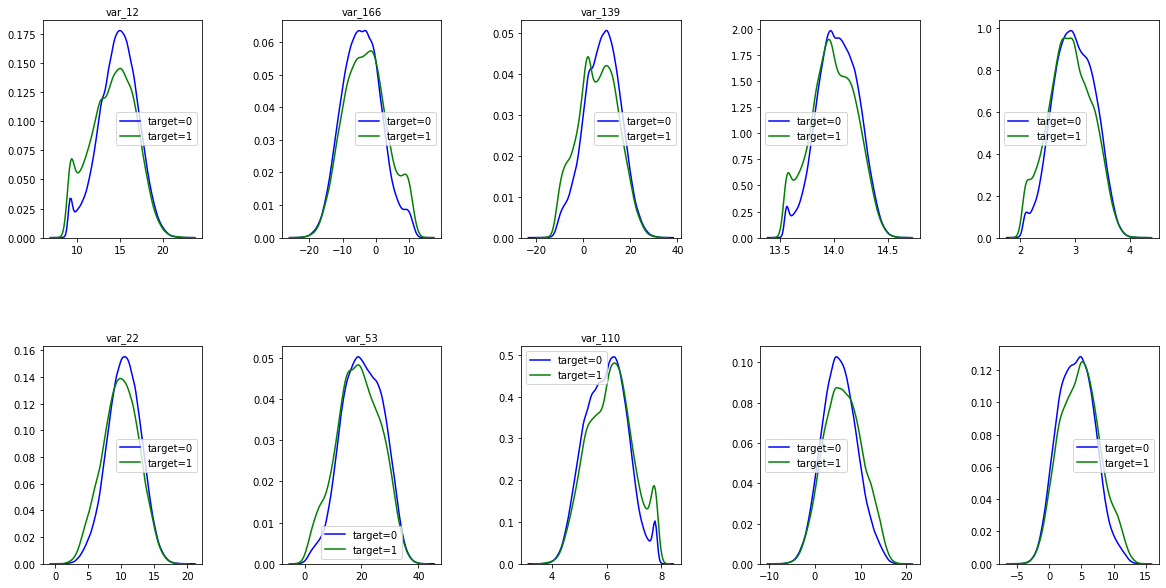

In [59]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for num, feature in enumerate(important_feature):
    try:
        train0, train1 = train[train['target'] == 0][feature].copy(), train[train['target'] == 1][feature].copy()
        sns.kdeplot(train0, ax=axes[num//5, num%5], color="blue", label="target=0")
        sns.kdeplot(train1, ax=axes[num//5, num%5], color="green", label="target=1")
    except RuntimeError:
        pass
    except KeyError:
        train0 = train[train['target'] == 0][feature].copy()
        sns.kdeplot(train0, ax=axes[num//3, num%5], color="blue", label="target=0")
    axes[num//5, num%3].set_title(feature, fontsize=10)

Строим PairPlor для пар признаков, которые с помощью случайного леса определили как наиболее значимые

C:\Users\Zharo\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


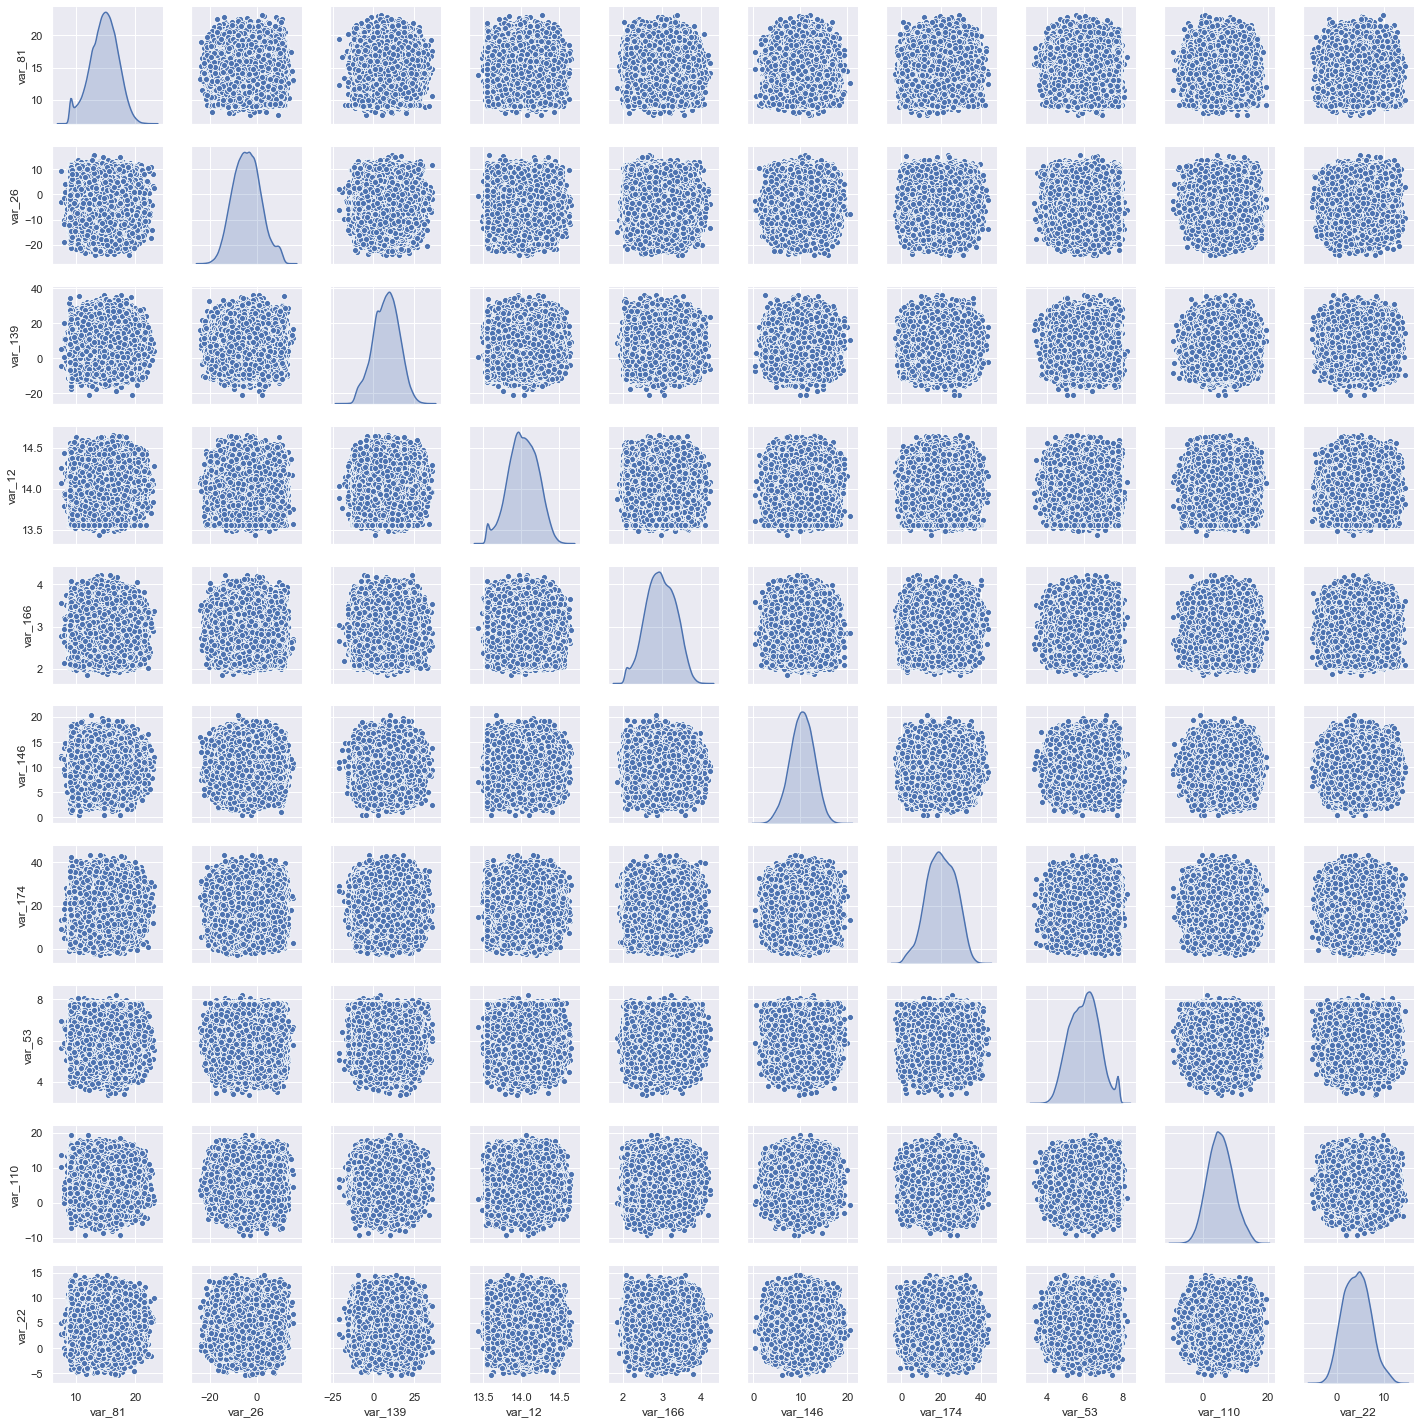

In [60]:
sns.set()

sns.pairplot(train[important_feature], size=2, kind="scatter", diag_kind="kde")
plt.show()

Никакой взаимосвязи между признаками визуально увидеть не удается

Scatter-plot между двумя наиболее значимыми признаками

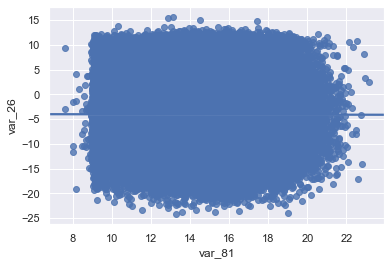

In [61]:
sns.regplot(
        x='var_81',
        y='var_26',
        data=train,
        scatter=True,
        fit_reg=True
    )

#### Kolmogorov-Smirnov Test

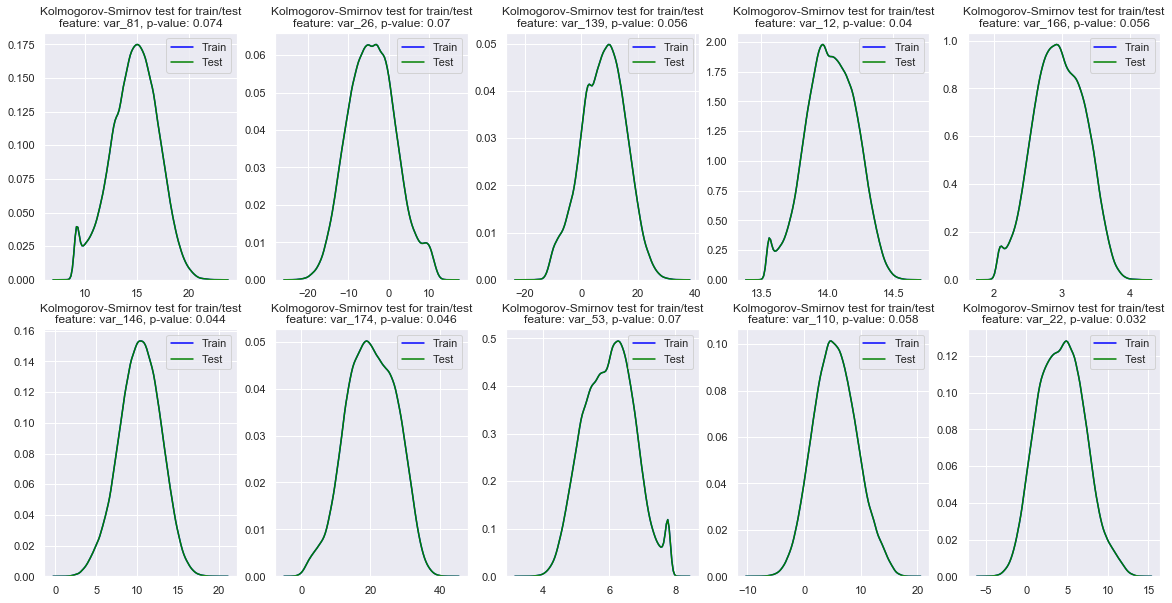

In [63]:
statistics_array = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(important_feature):
    statistic, pvalue = ks_2samp(
        train[feature].sample(500), test[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

Если p-value меньше 0.05 отклоняем гипотезу об одинаковом распределении признака на трейне и тесте.
Среди рассмотренных наиболее влияющих на модель признаков отклонить гипотезу об одинаком распределении на уровне значимости 0.05 следует для признаков 12, 146, 174, 22. Для остальных признаков отклонить гипотезу не можем

#### Population Stability Index

In [64]:
class PSI(BaseEstimator, TransformerMixin):
    """
    Вычисление PSI и отбор признаков на их основе.

    Parameters
    ----------
    threshold: float
        Порог для отбора переменных по PSI.
        Если PSI для переменной выше порога - переменная макрируется
        0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

    categorical_features: List[str], optional, default = None
        Список категориальных признаков для анализа.
        Опциональный параметр, по умолчанию, не используется, т.е.
        категориальные признаки отсутствуют.

    n_bins: int, optional, default = 20
        Количество бинов, на которые разбивается выборка.

    min_value: float, optional, default = 0.005
        Значение которое используется, если рассчитанный psi = 0.

    bin_type: string, optional, default = "quanitles"
        Способ разбиения на бины: "quantiles" or "bins".
        При выборе "quantiles" - выборка будет разбита на n_bins
        квантилей, при выборке "bins" - выборка будет разбита на
        n_bins бакетов с равным шагом между бакетами.
        Иные значения приводят к возникновению ValueError.

    Attributes
    ----------
    scores_: Dict[str, float]
        Словарь со значениями PSI,
        ключ словаря - название признака, значение - PSI-score.

    """
    def __init__(self,
                 threshold: float,
                 categorical_features: Optional[List[str]] = None,
                 bin_type: str = "quantiles",
                 min_value: float = 0.005,
                 n_bins: int = 20):

        self.threshold = threshold
        self.categorical_features = categorical_features
        self.min_value = min_value
        self.n_bins = n_bins
        if bin_type in ["quantiles", "bins"]:
            self.bin_type = bin_type
        else:
            raise ValueError(
                "Incorrect bin_type value. Expected 'quantiles' or 'bins', "
                f"but {bin_type} is transferred."
            )
        self.scores = {}

    def calculate_bins(self, data: pd.Series) -> np.array:
        """
        Вычисление границ бинов для разбиения выборки.

        Parameters
        ----------
        data: pandas.Series, shape = [n_samples, ]
            наблюдения из train-выборки.

        Returns
        -------
        bins: numpy.array, shape = [self.n_bins + 1]
            Список с границами бинов.

        """
        if self.bin_type == "quantiles":
            bins = np.linspace(0, 100, self.n_bins + 1)
            bins = [np.nanpercentile(data, x) for x in bins]

        else:
            bins = np.linspace(data.min(), data.max(), self.n_bins + 1)

        return np.unique(bins)

    def calculate_psi_in_bin(self, expected_score, actual_score) -> float:
        """
        Вычисление значения psi для одного бакета.

        Осуществляется проверка на равенство нулю expected_score и
        actual_score: если один из аргументов равен нулю, то его
        значение заменяется на self.min_value.

        Parameters
        ----------
        expected_score: float
            Ожидаемое значение.

        actual_score: float
            Наблюдаемое значение.

        Returns
        -------
        value: float
            Значение psi в бине.

        """
        if expected_score == 0:
            expected_score = self.min_value
        if actual_score == 0:
            actual_score = self.min_value

        value = (expected_score - actual_score)
        value = value * np.log(expected_score / actual_score)

        return value

    def calculate_psi(self, expected: pd.Series, actual: pd.Series, bins) -> float:
        """
        Расчет PSI для одной переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        bins: pandas.Series, shape = [self.n_bins, ]
            Бины для расчета PSI.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        expected_score = np.histogram(expected.fillna(-9999), bins)[0]
        expected_score = expected_score / expected.shape[0]

        actual_score = np.histogram(actual.fillna(-9999), bins)[0]
        actual_score = actual_score / actual.shape[0]

        psi_score = np.sum(
            self.calculate_psi_in_bin(exp_score, act_score)
            for exp_score, act_score in zip(expected_score, actual_score)
        )

        return psi_score

    def calculate_numeric_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для числовой переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = self.calculate_bins(expected)
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def calculate_categorical_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для категориальной переменной.
        PSI рассчитывается для каждого уникального значения категории.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = np.unique(expected).tolist()
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def fit(self, X, y=None):
        """
        Вычисление PSI-значения для всех признаков.

        Parameters
        ----------
        X: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        y: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        self
        """
        missed_columns = list(set(X.columns) - set(y.columns))

        if missed_columns:
            raise MissedColumnError(
                f"Missed {list(missed_columns)} columns in data.")

        if self.categorical_features:
            numeric_features = list(
                set(X.columns) - set(self.categorical_features)
            )
            for feature in self.categorical_features:
                self.scores[feature] = self.calculate_categorical_psi(
                    X[feature], y[feature]
                )
        else:
            numeric_features = X.columns

        for feature in tqdm(numeric_features):
            self.scores[feature] = self.calculate_numeric_psi(
                X[feature], y[feature]
            )
        return self

    def transform(self, X, y=None) -> pd.DataFrame:
        """
        Отбор переменных по self.threshold.
        Если PSI-score для переменной выше порога, то переменная
        помечается 0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

        Parameters
        ----------
        data: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        target: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        scores: pandas.DataFrame, shape = [n_features, 3]
            Датафрейм с PSI-анализом переменных.

        """
        check_is_fitted(self, "scores")
        scores = pd.Series(self.scores)
        scores = pd.DataFrame({"Variable": scores.index, "PSI": scores.values})
        scores["Selected"] = np.where(scores.PSI < self.threshold, 1, 0)
        scores = scores.sort_values(by="PSI")

        mask = scores["Selected"] == 1
        self.used_features = scores.loc[mask, "Variable"].tolist()

        return scores.reset_index(drop=True)

In [69]:
features_to_score = continuous_feature
psi = PSI(threshold=0.01)

In [71]:
score_result = psi.fit_transform(
    X=train[features_to_score],
    y=test[features_to_score]
)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.01it/s]


In [85]:
score_result.head()

,Variable,PSI,Selected
0,var_154,0.000085,1
1,var_156,0.000132,1
2,var_5,0.000138,1
3,var_148,0.000150,1
4,var_35,0.000151,1


In [83]:
score_result[score_result.Selected == 1].Variable.count()

200

Все значения получились менее установленного нами порога 0.01, следовательно их можно считать стабильными во времени.

#### Adversarial Validation

In [86]:
X_adv = pd.concat([
    train[features_to_score], test[features_to_score]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [87]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5116
Wall time: 16min 9s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

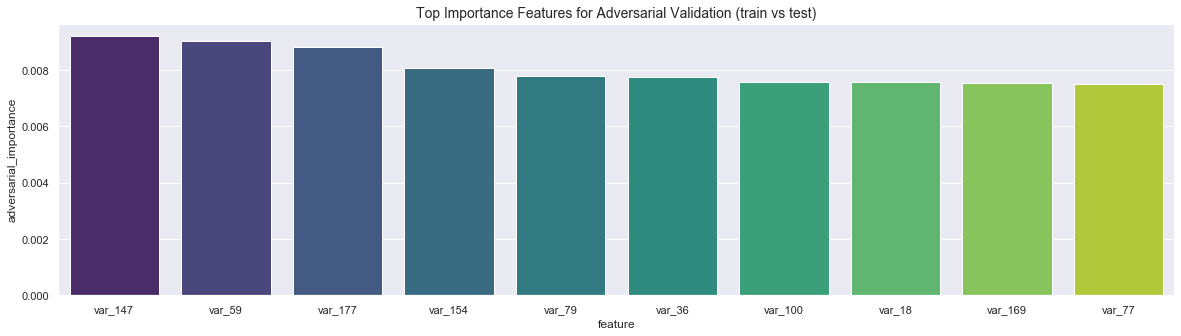

In [88]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

Значение CV-score: 0.5116 близко к 0.5, поэтому можно считать, что распределение на трейне и тексте совпадают. Наиболее значимые признаки с точки зрения различия распределений: 147, 59, 177.